In [1]:
import numpy as np
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
%matplotlib inline

# Data

### Load

In [2]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing_data = fetch_california_housing()
print(housing_data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
data = pd.DataFrame(housing_data['data'], columns=housing_data['feature_names']).assign(MedianPrice=housing_data['target'])
data.sample(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianPrice
1316,3.5368,34.0,5.965142,1.034858,1316.0,2.867102,38.00,-121.80,1.225
16843,4.7625,35.0,5.303942,0.994813,3004.0,3.116183,37.63,-122.44,2.813
19153,3.1781,23.0,4.926391,1.055655,1493.0,2.680431,38.34,-122.71,1.620
8431,2.6961,19.0,4.204607,1.243902,2033.0,2.754743,33.93,-118.36,2.125
2402,2.6058,26.0,5.789157,1.021084,1148.0,3.457831,36.62,-119.34,0.922
14260,1.3194,14.0,3.455696,1.000000,827.0,3.489451,32.70,-117.12,0.905
14446,2.9200,37.0,4.091139,1.065823,650.0,1.645570,32.81,-117.26,3.265
9097,5.0839,25.0,6.039216,1.150980,1558.0,3.054902,34.73,-118.61,1.567
16202,1.4688,44.0,3.642487,0.924870,1489.0,3.857513,37.94,-121.28,0.568
16890,5.7837,49.0,6.137037,0.985185,613.0,2.270370,37.59,-122.38,3.781


In [4]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianPrice
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### Train test Split

In [5]:
from sklearn.model_selection import train_test_split
X, y = data.drop('MedianPrice', axis=1), data.MedianPrice
train_test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_ratio, random_state=0, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16512, 8), (16512,), (4128, 8), (4128,))

# Baseline

In [6]:
from sklearn.metrics import mean_squared_error
models_errors = {}

average_train = y_train.mean()
y_pred = np.ones_like(y_test) * average_train
model_mse = mean_squared_error(y_test, y_pred)
models_errors['Baseline'] = model_mse
model_mse

1.304343147930785

# Linear Regressor

In [7]:
def check_regressor(regressor, X_train, y_train, X_test, y_test):
    # Fit regression model
    regressor.fit(X_train, y_train)

    # Predict
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    y_pred_train = regressor.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    
    model_name = regressor.__class__.__name__
    print('{0} mean squared error is {1:.4f} (mse train {2:.4f})'
          .format(model_name, mse, mse_train))
    return mse

from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()
model_mse = check_regressor(linear_regressor, X_train, y_train, X_test, y_test)
model_name = linear_regressor.__class__.__name__
models_errors[model_name] = model_mse

LinearRegression mean squared error is 0.5290 (mse train 0.5234)


# Nearest Neighbors Regressor

In [8]:
from sklearn.neighbors import KNeighborsRegressor

k = 15
nearest_neighbors = KNeighborsRegressor(k)
model_mse = check_regressor(nearest_neighbors, X_train, y_train, X_test, y_test)
model_name = nearest_neighbors.__class__.__name__
models_errors[model_name] = model_mse

KNeighborsRegressor mean squared error is 1.1101 (mse train 0.9875)


Why did kNN perform so bad? hint: check out the statistics in the data description

# Decision Tree Regressor

In [9]:
from sklearn.tree import DecisionTreeRegressor

max_depth = 8
decision_tree = DecisionTreeRegressor(max_depth=max_depth, random_state=0)
model_mse = check_regressor(decision_tree, X_train, y_train, X_test, y_test)
model_name = decision_tree.__class__.__name__
models_errors[model_name] = model_mse

DecisionTreeRegressor mean squared error is 0.4460 (mse train 0.3282)


### Visualize Tree

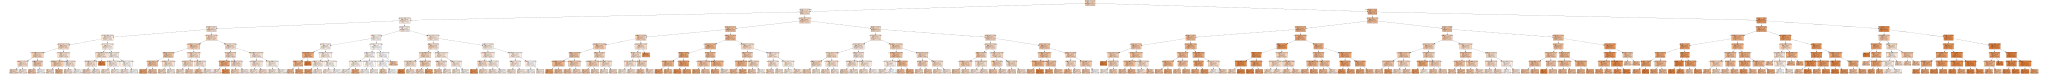

In [10]:
def visualize_tree(tree, features):
    graph = Source(export_graphviz(tree, feature_names=features, filled = True))
    display(SVG(graph.pipe(format='svg')))
    
visualize_tree(decision_tree, features=housing_data['feature_names'])

# Random Forest Regressor

In [11]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = 100
max_depth = 8
random_forest = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
model_mse = check_regressor(random_forest, X_train, y_train, X_test, y_test)
model_name = random_forest.__class__.__name__
models_errors[model_name] = model_mse

RandomForestRegressor mean squared error is 0.3491 (mse train 0.2663)


# Performance Comparision

In [12]:
import pandas as pd
pd.Series(models_errors, name='mean squared error').sort_values().to_frame()

,mean squared error
RandomForestRegressor,0.349111
DecisionTreeRegressor,0.446046
LinearRegression,0.528984
KNeighborsRegressor,1.110084
Baseline,1.304343
